In [1]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel('/content/drive/MyDrive/my_data_DS317/train_update.xlsx')
df.drop(['gioitinh'], axis=1)
df.head()

,mssv,namsinh,gioitinh,drl,diem_tt,dtb_toankhoa,dtb_tichluy,sotc_tichluy,diemtbhk_1,diemtbhk_2,diemtbhk_3,diemtbhk_4,diemtbhk_5,diemtbhk_6,diemtbhk_7,diemtbhk_8
0,39B39397XPvAibaEXe/vGZ1xWLvpK7wMZlgBlCBs,19,0,75.198135,30.0,9.37,9.37,24,9.37,9.34,9.40,9.370000,9.370000,9.370000,9.370000,9.370000
1,3AB392AFXPvAibaEXe/NRwqjPAC0MKjf0QSiSLjM,17,0,85.000000,26.5,7.07,7.07,139,7.00,6.74,6.25,6.230000,7.150000,6.920000,6.970000,7.600000
2,BEC54CF0XPvAibaEXe/qZKhoIW7F1rbPON7lHJUG,19,0,82.000000,30.0,6.54,6.54,18,6.54,6.54,6.54,6.540000,6.540000,6.540000,6.540000,6.540000
3,43386D57XPvAibaEXe/nw3DhNQnHfzJZvI0o00SJ,20,0,75.655535,22.0,1.83,1.83,4,3.56,0.00,1.78,1.780000,1.780000,1.780000,1.780000,1.780000
4,8F1A725FXPvAibaEXe88DMpF1KL2K3HyZfgFjAif,19,0,100.000000,30.0,9.31,9.31,64,9.21,9.32,9.41,9.313333,9.313333,9.313333,9.313333,9.313333


In [6]:
df_test = pd.read_excel('/content/drive/MyDrive/my_data_DS317/test_update.xlsx')
df_test.drop(['gioitinh'], axis=1)
df_test.head()

,mssv,namsinh,gioitinh,drl,diem_tt,dtb_toankhoa,dtb_tichluy,sotc_tichluy,diemtbhk_1,diemtbhk_2,diemtbhk_3,diemtbhk_4,diemtbhk_5,diemtbhk_6,diemtbhk_7,diemtbhk_8
0,14EEA146XPvAibaEXe/2sgPA+OKAks3AV3zsZSFH,22,0,82.105913,26.762789,8.77,8.77,123,8.61,8.79,9.01,9.04,8.63,8.620,8.530,8.747143
1,4A2628C7XPvAibaEXe9urngX21O5XaWExeziRFls,22,1,82.105913,30.000000,8.42,8.42,130,9.11,8.64,7.78,8.60,8.45,8.300,9.300,8.597143
2,44634117XPvAibaEXe+WdrMfsV/1fSPAGTu3hQ5U,22,0,82.105913,22.350000,7.73,7.73,137,7.83,7.46,7.53,7.67,7.89,8.030,7.750,7.737143
3,8A7BA5ACXPvAibaEXe8FNnc+c+WuJHdW9KyIp7Nl,19,0,100.000000,30.000000,6.52,6.52,83,7.63,7.21,7.70,7.05,1.67,6.252,6.252,6.252000
4,A3A77666XPvAibaEXe/4WyTnp6RTwi1hkjCNtuCX,20,0,75.655535,24.250000,6.50,6.50,148,6.02,6.75,6.79,6.26,5.21,5.580,6.450,6.690000


In [7]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    mpe = np.mean((y_true - y_pred) / y_true) * 100 if np.all(y_true != 0) else np.nan
    r2 = r2_score(y_true, y_pred)
    return {"R2 Score": r2, "MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape, "MPE": mpe}

In [52]:
models = {
    "TabNetRegressor": TabNetRegressor(
        n_d=48, n_a=48, n_steps=5,
        #random_state=42
    )
}

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [54]:
initial_columns = ['namsinh', 'dtb_toankhoa', 'dtb_tichluy', 'sotc_tichluy', 'diemtbhk_1']

# Lặp qua từng cột làm y
results = []
current_X_columns = initial_columns.copy()

for i in range(len(initial_columns) + 2, len(df.columns) - 1):
    if i + 2 >= len(df.columns):
        break

    # Xác định cột mục tiêu hiện tại
    target_column = df.columns[i + 2]

    # Chuẩn bị dữ liệu huấn luyện và kiểm tra
    X_train = df[current_X_columns]
    y_train = df[target_column]

    X_test = df_test[current_X_columns]
    y_test = df_test[target_column]

    # Huấn luyện và đánh giá mô hình
    for model_name, model in models.items():
        # Huấn luyện mô hình
        model.fit(
            X_train.values, y_train.values.reshape(-1, 1),
            max_epochs=100,
            patience=10
        )

        # Lưu mô hình với tên chứa cột mục tiêu
        saving_path_name = f"./models/{model_name}_{target_column}.pth"
        saved_filepath = model.save_model(saving_path_name)

        # Dự đoán
        y_pred = model.predict(X_test.values)

        # Tính toán các độ đo
        metrics = calculate_metrics(y_test, y_pred)
        metrics["Model"] = model_name
        metrics["Target Column"] = target_column
        results.append(metrics)

    # Cập nhật danh sách cột X cho vòng tiếp theo
    current_X_columns.append(target_column)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 8.86377 |  0:00:01s
epoch 1  | loss: 1.16989 |  0:00:03s
epoch 2  | loss: 0.98069 |  0:00:05s
epoch 3  | loss: 0.9284  |  0:00:07s
epoch 4  | loss: 0.89176 |  0:00:09s
epoch 5  | loss: 0.91285 |  0:00:11s
epoch 6  | loss: 0.86546 |  0:00:13s
epoch 7  | loss: 0.86167 |  0:00:14s
epoch 8  | loss: 0.84257 |  0:00:16s
epoch 9  | loss: 0.91161 |  0:00:18s
epoch 10 | loss: 0.98676 |  0:00:19s
epoch 11 | loss: 0.90807 |  0:00:22s
epoch 12 | loss: 0.85241 |  0:00:24s
epoch 13 | loss: 0.82569 |  0:00:26s
epoch 14 | loss: 0.83057 |  0:00:27s
epoch 15 | loss: 0.81304 |  0:00:29s
epoch 16 | loss: 0.80122 |  0:00:31s
epoch 17 | loss: 0.80488 |  0:00:32s
epoch 18 | loss: 0.82951 |  0:00:34s
epoch 19 | loss: 0.80419 |  0:00:36s
epoch 20 | loss: 0.86213 |  0:00:39s
epoch 21 | loss: 0.85892 |  0:00:40s
epoch 22 | loss: 0.80009 |  0:00:42s
epoch 23 | loss: 0.79963 |  0:00:44s
epoch 24 | loss: 0.79834 |  0:00:45s
epoch 25 | loss: 0.83441 |  0:00:47s
epoch 26 | loss: 0.79688 |  0:00:49s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.1459 |  0:00:01s
epoch 1  | loss: 1.04105 |  0:00:03s
epoch 2  | loss: 0.84904 |  0:00:05s
epoch 3  | loss: 0.7613  |  0:00:07s
epoch 4  | loss: 0.81257 |  0:00:09s
epoch 5  | loss: 0.78437 |  0:00:11s
epoch 6  | loss: 0.74773 |  0:00:13s
epoch 7  | loss: 0.70857 |  0:00:14s
epoch 8  | loss: 0.68282 |  0:00:16s
epoch 9  | loss: 0.66456 |  0:00:18s
epoch 10 | loss: 0.65604 |  0:00:20s
epoch 11 | loss: 0.68578 |  0:00:22s
epoch 12 | loss: 0.66066 |  0:00:24s
epoch 13 | loss: 0.66907 |  0:00:26s
epoch 14 | loss: 0.61353 |  0:00:28s
epoch 15 | loss: 0.62294 |  0:00:29s
epoch 16 | loss: 0.62801 |  0:00:31s
epoch 17 | loss: 0.62992 |  0:00:32s
epoch 18 | loss: 0.63764 |  0:00:34s
epoch 19 | loss: 0.67532 |  0:00:37s
epoch 20 | loss: 0.69257 |  0:00:39s
epoch 21 | loss: 0.60641 |  0:00:41s
epoch 22 | loss: 0.60427 |  0:00:42s
epoch 23 | loss: 0.60942 |  0:00:44s
epoch 24 | loss: 0.60999 |  0:00:46s
epoch 25 | loss: 0.59587 |  0:00:47s
epoch 26 | loss: 0.6053  |  0:00:49s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 10.79421|  0:00:01s
epoch 1  | loss: 1.83553 |  0:00:03s
epoch 2  | loss: 1.52723 |  0:00:05s
epoch 3  | loss: 1.65521 |  0:00:07s
epoch 4  | loss: 1.4941  |  0:00:09s
epoch 5  | loss: 1.32017 |  0:00:11s
epoch 6  | loss: 1.31198 |  0:00:12s
epoch 7  | loss: 1.29601 |  0:00:14s
epoch 8  | loss: 1.29222 |  0:00:16s
epoch 9  | loss: 1.31192 |  0:00:18s
epoch 10 | loss: 1.2792  |  0:00:20s
epoch 11 | loss: 1.27868 |  0:00:22s
epoch 12 | loss: 1.37815 |  0:00:24s
epoch 13 | loss: 1.3041  |  0:00:26s
epoch 14 | loss: 1.2484  |  0:00:27s
epoch 15 | loss: 1.23088 |  0:00:29s
epoch 16 | loss: 1.20376 |  0:00:31s
epoch 17 | loss: 1.22062 |  0:00:32s
epoch 18 | loss: 1.20306 |  0:00:35s
epoch 19 | loss: 1.22595 |  0:00:37s
epoch 20 | loss: 1.30964 |  0:00:39s
epoch 21 | loss: 1.23095 |  0:00:41s
epoch 22 | loss: 1.20514 |  0:00:42s
epoch 23 | loss: 1.20069 |  0:00:44s
epoch 24 | loss: 1.24041 |  0:00:46s
epoch 25 | loss: 1.19758 |  0:00:47s
epoch 26 | loss: 1.29931 |  0:00:50s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 18.47699|  0:00:01s
epoch 1  | loss: 1.73799 |  0:00:03s
epoch 2  | loss: 0.95712 |  0:00:05s
epoch 3  | loss: 0.83087 |  0:00:08s
epoch 4  | loss: 0.87727 |  0:00:09s
epoch 5  | loss: 0.77807 |  0:00:11s
epoch 6  | loss: 0.75828 |  0:00:13s
epoch 7  | loss: 0.7802  |  0:00:14s
epoch 8  | loss: 0.83452 |  0:00:16s
epoch 9  | loss: 0.78935 |  0:00:18s
epoch 10 | loss: 0.76434 |  0:00:20s
epoch 11 | loss: 0.74243 |  0:00:22s
epoch 12 | loss: 0.70018 |  0:00:24s
epoch 13 | loss: 0.65723 |  0:00:26s
epoch 14 | loss: 0.64963 |  0:00:27s
epoch 15 | loss: 0.65351 |  0:00:29s
epoch 16 | loss: 0.64932 |  0:00:31s
epoch 17 | loss: 0.67985 |  0:00:33s
epoch 18 | loss: 0.68416 |  0:00:35s
epoch 19 | loss: 0.64308 |  0:00:37s
epoch 20 | loss: 0.6443  |  0:00:39s
epoch 21 | loss: 0.62977 |  0:00:40s
epoch 22 | loss: 0.63299 |  0:00:42s
epoch 23 | loss: 0.62312 |  0:00:44s
epoch 24 | loss: 0.61989 |  0:00:45s
epoch 25 | loss: 0.64134 |  0:00:48s
epoch 26 | loss: 0.64987 |  0:00:50s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 11.92541|  0:00:01s
epoch 1  | loss: 2.77648 |  0:00:03s
epoch 2  | loss: 1.56158 |  0:00:06s
epoch 3  | loss: 1.24683 |  0:00:08s
epoch 4  | loss: 1.39471 |  0:00:10s
epoch 5  | loss: 1.27129 |  0:00:11s
epoch 6  | loss: 1.11897 |  0:00:13s
epoch 7  | loss: 1.057   |  0:00:15s
epoch 8  | loss: 1.16229 |  0:00:16s
epoch 9  | loss: 1.10949 |  0:00:19s
epoch 10 | loss: 1.17511 |  0:00:21s
epoch 11 | loss: 1.1235  |  0:00:23s
epoch 12 | loss: 1.02984 |  0:00:24s
epoch 13 | loss: 1.0085  |  0:00:26s
epoch 14 | loss: 1.05061 |  0:00:28s
epoch 15 | loss: 1.01969 |  0:00:30s
epoch 16 | loss: 1.06784 |  0:00:31s
epoch 17 | loss: 1.03871 |  0:00:34s
epoch 18 | loss: 1.09117 |  0:00:36s
epoch 19 | loss: 1.0754  |  0:00:38s
epoch 20 | loss: 1.05237 |  0:00:39s
epoch 21 | loss: 1.01293 |  0:00:41s
epoch 22 | loss: 1.00432 |  0:00:43s
epoch 23 | loss: 1.0284  |  0:00:44s
epoch 24 | loss: 0.99399 |  0:00:46s
epoch 25 | loss: 1.06633 |  0:00:49s
epoch 26 | loss: 1.03612 |  0:00:51s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 12.994  |  0:00:02s
epoch 1  | loss: 1.48125 |  0:00:04s
epoch 2  | loss: 1.01402 |  0:00:06s
epoch 3  | loss: 1.1138  |  0:00:08s
epoch 4  | loss: 0.91364 |  0:00:09s
epoch 5  | loss: 0.81772 |  0:00:11s
epoch 6  | loss: 0.80863 |  0:00:13s
epoch 7  | loss: 0.85055 |  0:00:15s
epoch 8  | loss: 0.70539 |  0:00:17s
epoch 9  | loss: 0.7121  |  0:00:19s
epoch 10 | loss: 0.68204 |  0:00:21s
epoch 11 | loss: 0.67926 |  0:00:23s
epoch 12 | loss: 0.66504 |  0:00:24s
epoch 13 | loss: 0.74246 |  0:00:26s
epoch 14 | loss: 0.81879 |  0:00:28s
epoch 15 | loss: 0.8247  |  0:00:30s
epoch 16 | loss: 0.71359 |  0:00:33s
epoch 17 | loss: 0.68054 |  0:00:34s
epoch 18 | loss: 0.6449  |  0:00:36s
epoch 19 | loss: 0.6473  |  0:00:38s
epoch 20 | loss: 0.68613 |  0:00:39s
epoch 21 | loss: 0.65872 |  0:00:41s
epoch 22 | loss: 0.65221 |  0:00:43s
epoch 23 | loss: 0.65136 |  0:00:45s
epoch 24 | loss: 0.65742 |  0:00:48s
epoch 25 | loss: 0.62358 |  0:00:49s
epoch 26 | loss: 0.60817 |  0:00:51s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 9.32918 |  0:00:01s
epoch 1  | loss: 1.96069 |  0:00:03s
epoch 2  | loss: 1.83055 |  0:00:05s
epoch 3  | loss: 1.77762 |  0:00:06s
epoch 4  | loss: 1.669   |  0:00:08s
epoch 5  | loss: 1.58538 |  0:00:11s
epoch 6  | loss: 1.55182 |  0:00:13s
epoch 7  | loss: 1.53958 |  0:00:15s
epoch 8  | loss: 1.49926 |  0:00:16s
epoch 9  | loss: 1.46863 |  0:00:18s
epoch 10 | loss: 1.45783 |  0:00:20s
epoch 11 | loss: 1.45899 |  0:00:21s
epoch 12 | loss: 1.46981 |  0:00:23s
epoch 13 | loss: 1.36567 |  0:00:26s
epoch 14 | loss: 1.40001 |  0:00:28s
epoch 15 | loss: 1.46324 |  0:00:29s
epoch 16 | loss: 1.47621 |  0:00:31s
epoch 17 | loss: 1.38762 |  0:00:33s
epoch 18 | loss: 1.38302 |  0:00:35s
epoch 19 | loss: 1.36246 |  0:00:36s
epoch 20 | loss: 1.34417 |  0:00:38s
epoch 21 | loss: 1.41866 |  0:00:41s
epoch 22 | loss: 1.39825 |  0:00:43s
epoch 23 | loss: 1.38802 |  0:00:44s
epoch 24 | loss: 1.42135 |  0:00:46s
epoch 25 | loss: 1.33057 |  0:00:48s
epoch 26 | loss: 1.36668 |  0:00:50s
e

In [50]:
df_test.columns[1:15] # Get column names from the DataFrame directly using slicing

Index(['namsinh', 'gioitinh', 'drl', 'diem_tt', 'dtb_toankhoa', 'dtb_tichluy',
       'sotc_tichluy', 'diemtbhk_1', 'diemtbhk_2', 'diemtbhk_3', 'diemtbhk_4',
       'diemtbhk_5', 'diemtbhk_6', 'diemtbhk_7'],
      dtype='object')

In [19]:
# Tạo DataFrame kết quả
results_df = pd.DataFrame(results)
results_df.to_csv("tabnet_model_results.csv", index=False)

print(results_df)

   R2 Score       MSE      RMSE       MAE  MAPE  MPE            Model  \
0  0.820141  0.803587  0.896430  0.561779   NaN  NaN  TabNetRegressor   
1  0.889016  0.440653  0.663817  0.410897   NaN  NaN  TabNetRegressor   
2  0.788095  0.897884  0.947567  0.523216   NaN  NaN  TabNetRegressor   
3  0.859814  0.576141  0.759039  0.482460   NaN  NaN  TabNetRegressor   
4  0.778324  1.017483  1.008704  0.492588   NaN  NaN  TabNetRegressor   
5  0.895478  0.442563  0.665254  0.383286   NaN  NaN  TabNetRegressor   
6  0.711073  1.460685  1.208588  0.629215   NaN  NaN  TabNetRegressor   

  Target Column  
0    diemtbhk_2  
1    diemtbhk_3  
2    diemtbhk_4  
3    diemtbhk_5  
4    diemtbhk_6  
5    diemtbhk_7  
6    diemtbhk_8  


In [55]:
results_df

,R2 Score,MSE,RMSE,MAE,MAPE,MPE,Model,Target Column
0,0.820141,0.803587,0.896430,0.561779,NaN,NaN,TabNetRegressor,diemtbhk_2
1,0.889016,0.440653,0.663817,0.410897,NaN,NaN,TabNetRegressor,diemtbhk_3
2,0.788095,0.897884,0.947567,0.523216,NaN,NaN,TabNetRegressor,diemtbhk_4
3,0.859814,0.576141,0.759039,0.482460,NaN,NaN,TabNetRegressor,diemtbhk_5
4,0.778324,1.017483,1.008704,0.492588,NaN,NaN,TabNetRegressor,diemtbhk_6
5,0.895478,0.442563,0.665254,0.383286,NaN,NaN,TabNetRegressor,diemtbhk_7
6,0.711073,1.460685,1.208588,0.629215,NaN,NaN,TabNetRegressor,diemtbhk_8


In [20]:
print(results_df['R2 Score'].mean())
print(results_df['MSE'].mean())
print(results_df['RMSE'].mean())
print(results_df['MAE'].mean())

0.8202772636253431
0.8055707996323241
0.878485668744158
0.4976345888535236


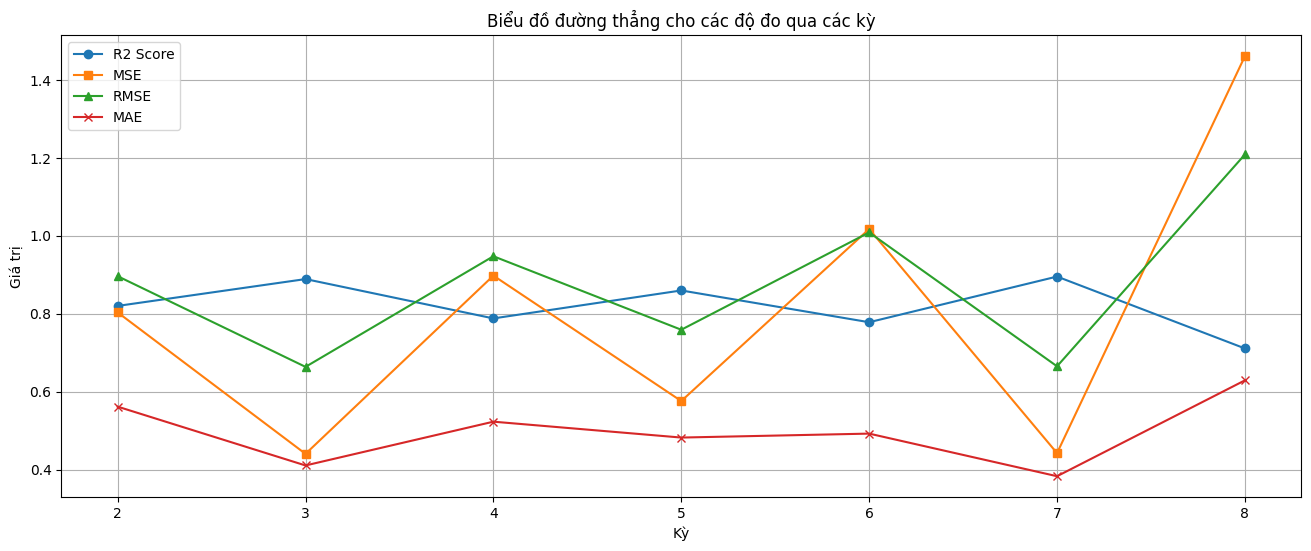

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Đọc dữ liệu từ DataFrame (hoặc tạo thủ công nếu cần)
data = results_df # Thay 'your_file.csv' bằng tên file thực tế

# Thiết lập trục x bắt đầu từ kỳ 2
x = data.index + 2  # Bắt đầu từ kỳ 2

# Vẽ biểu đồ
plt.figure(figsize=(16, 6))

plt.plot(x, data['R2 Score'], marker='o', label='R2 Score')
plt.plot(x, data['MSE'], marker='s', label='MSE')
plt.plot(x, data['RMSE'], marker='^', label='RMSE')
plt.plot(x, data['MAE'], marker='x', label='MAE')

# Thêm nhãn và tiêu đề
plt.xlabel('Kỳ')
plt.ylabel('Giá trị')
plt.title('Biểu đồ đường thẳng cho các độ đo qua các kỳ')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()
